# Lab 2 : Edge Detection and Hough Transform
Below is the code given from the assignment. 


## Importing Libraries and prerequisites
Below are the all the functions and libraries that are used in this assignment. 

In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
from scipy.signal import convolve2d, correlate2d
import matplotlib.pyplot as plt

from Functions import *
from gaussfft import gaussfft

In [2]:
# The derivatives
# First order derivative
dx_filter = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0.5, 0, -0.5, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
)
dy_filter = dx_filter.T

# Second order derivative
dxx_filter = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, -2, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
)
dxy_filter = convolve2d(dx_filter, dy_filter, mode="same")
dyy_filter = dxx_filter.T

# Third order derivative --> We want the same size thereby same
dxxx_filter = convolve2d(dxx_filter, dx_filter, mode="same")
dxxy_filter = convolve2d(dxx_filter, dy_filter, mode="same")
dxyy_filter = convolve2d(dxy_filter, dy_filter, mode="same")
dyyy_filter = convolve2d(dyy_filter, dy_filter, mode="same")

Here are all the functions that were given to us to fill in 

In [3]:
# Computes delta x using central difference
def delta_x(image):
    # Using a 3x3 filter mask --> from the lecture
    dx = np.array([[0, 0, 0], [0.5, 0, -0.5], [0, 0, 0]])
    dx_mask = convolve2d(image, dx, mode="same")
    return dx_mask


# Computes delta y using central difference
def delta_y(image):
    # Using a 3x3 filter mask --> from the lecture
    dy = np.array([[0, 0.5, 0], [0, 0, 0], [0, -0.5, 0]])
    dy_mask = convolve2d(image, dy, mode="same")
    return dy_mask


def sobel_x(image):
    # Using a 3x3 filter mask --> from the lecture
    dx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    dx_mask = convolve2d(image, dx, mode="same")
    return dx_mask


def sobel_y(image):
    """Calculate image dy using Sobel filter"""
    # Create Sobel filter
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    # Convolve image with Sobel filter
    dy = convolve2d(image, sobel_y, mode="same")
    return dy


# @TODO: Implement this function
def Lv(inpic, shape="same"):
    gradient_x = sobel_x(inpic)
    gradient_y = sobel_y(inpic)
    # Return the sum of the squares of the gradients
    return np.sqrt((gradient_x**2) + (gradient_y**2))


# @TODO: Implement this function
def Lvvtilde(input_image, shape="same"):
    # First derivative of input_image
    deriv_x = convolve2d(input_image, dx_filter, mode=shape)
    deriv_y = convolve2d(input_image, dy_filter, mode=shape)

    # Second derivative of input_image
    deriv_xx = convolve2d(input_image, dxx_filter, mode=shape)
    deriv_yy = convolve2d(input_image, dyy_filter, mode=shape)
    deriv_xy = convolve2d(input_image, dxy_filter, mode=shape)

    LVV_tilde = (
        (deriv_x**2) * deriv_xx
        + 2 * deriv_x * deriv_y * deriv_xy
        + (deriv_y**2) * deriv_yy
    )
    return LVV_tilde


# @TODO: Implement this function
def Lvvvtilde(inpic, shape="same"):
    # First derivative of input_image
    deriv_x = convolve2d(inpic, dx_filter, mode=shape)
    deriv_y = convolve2d(inpic, dy_filter, mode=shape)

    # Second derivative of input_image
    deriv_xx = convolve2d(inpic, dxx_filter, mode=shape)
    deriv_yy = convolve2d(inpic, dyy_filter, mode=shape)
    deriv_xy = convolve2d(inpic, dxy_filter, mode=shape)

    # Third derivative of input_image
    deriv_xxx = convolve2d(inpic, dxxx_filter, mode=shape)
    deriv_xxy = convolve2d(inpic, dxxy_filter, mode=shape)
    deriv_xyy = convolve2d(inpic, dxyy_filter, mode=shape)
    deriv_yyy = convolve2d(inpic, dyyy_filter, mode=shape)

    LVVV_tilde = (
        (deriv_x**3) * deriv_xxx
        + 3 * (deriv_x**2) * deriv_y * deriv_xxy
        + 3 * deriv_x * (deriv_y**2) * deriv_xyy
        + (deriv_y**3) * deriv_yyy
    )
    return LVVV_tilde


# @TODO: Implement this function
def extractedge(inpic, scale, threshold, shape="same"):
    # Blur the image
    blur = gaussfft(inpic, scale)

    # Gradient magnitude
    gradient_magnitude = Lv(blur, shape)

    # Laplacian of Gaussian
    lvv = Lvvtilde(blur, shape)
    # Third order derivative
    lvvv = Lvvvtilde(blur, shape)

    # Remove noise detected by the Laplacian of Gaussian
    laplacian_mask = gradient_magnitude > threshold

    # When third order derivative is negative -->
    Lvvv_mask = lvvv < 0

    curves = zerocrosscurves(lvv, Lvvv_mask)
    contours = thresholdcurves(curves, laplacian_mask)
    return contours


### Question 1
What do you expect the results to look like and why? Compare the size of dxtools with the size of tools. Why are these sizes different?

**Answer** <br>
I used both the central differences and the sobel operator to find the edges of the image. The sobel operator seems to catches the edges slighly better than the central differences. <br>
The images shows the edges in the X and Y direction depending on the direction of the filter used to find the edges. The sizes of the tools seems slighly smaller, probably because it's not possible to slide the filter over the border of the image. 

<br>
Below is the code

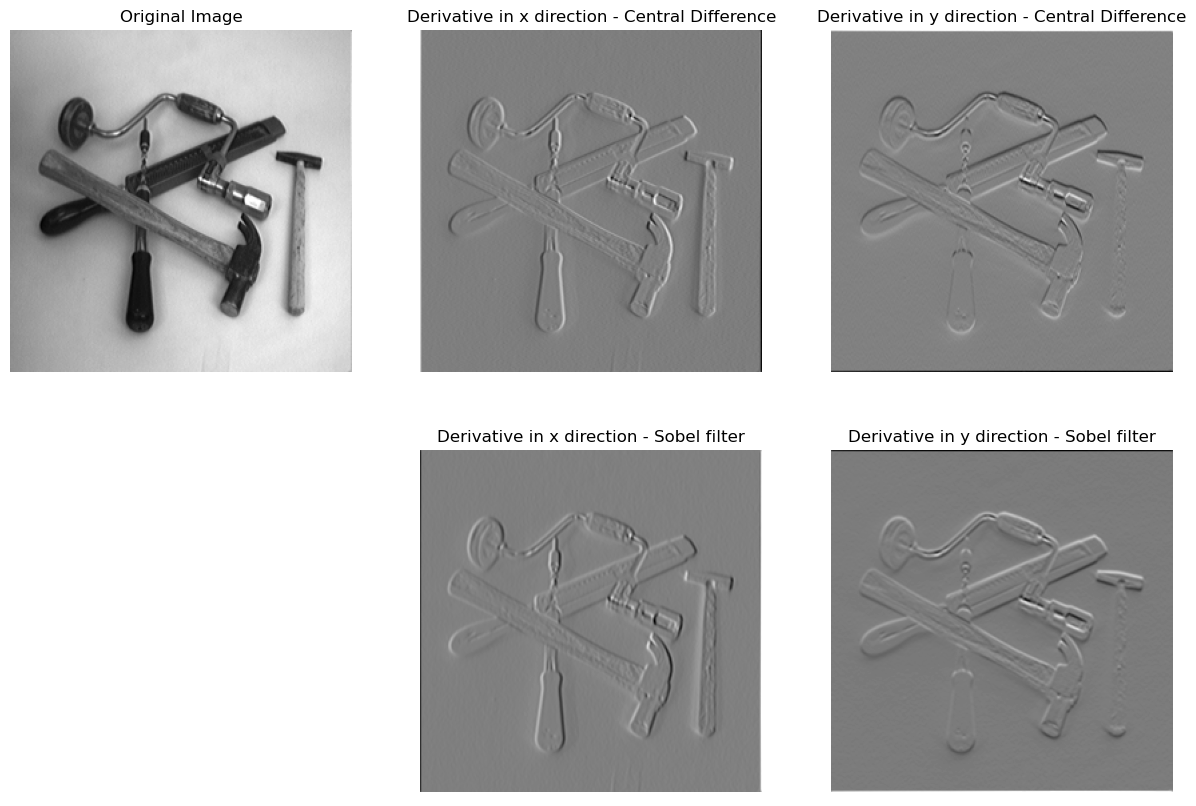

In [4]:
def q1():
    tools = np.load("Images-npy/few256.npy")

    deriv_x = delta_x(tools)
    deriv_y = delta_y(tools)

    sobel_x_img = sobel_x(tools)
    sobel_y_img = sobel_y(tools)

    # Create a figure with 2x3 subplots
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the original image
    ax[0, 0].imshow(tools, cmap="gray")
    ax[0, 0].set_title("Original Image")
    ax[0, 0].axis("off")

    # Plot the derivative in x direction
    ax[0, 1].imshow(deriv_x, cmap="gray")
    ax[0, 1].set_title("Derivative in x direction - Central Difference")
    ax[0, 1].axis("off")

    # Plot the derivative in y direction
    ax[0, 2].imshow(deriv_y, cmap="gray")
    ax[0, 2].set_title("Derivative in y direction - Central Difference")
    ax[0, 2].axis("off")

    # Plot the derivative in x direction
    ax[1, 1].imshow(sobel_x_img, cmap="gray")
    ax[1, 1].set_title("Derivative in x direction - Sobel filter")
    ax[1, 1].axis("off")

    # Plot the derivative in y direction
    ax[1, 2].imshow(sobel_y_img, cmap="gray")
    ax[1, 2].set_title("Derivative in y direction - Sobel filter")
    ax[1, 2].axis("off")

    # Remove the axis on subplot [1, 0]
    ax[1, 0].axis("off")

    plt.show()


q1()

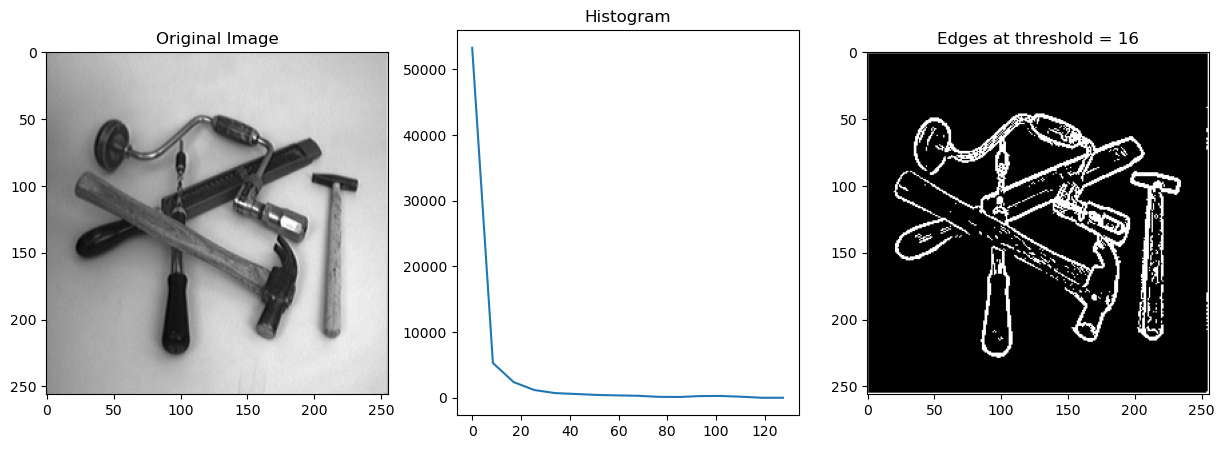

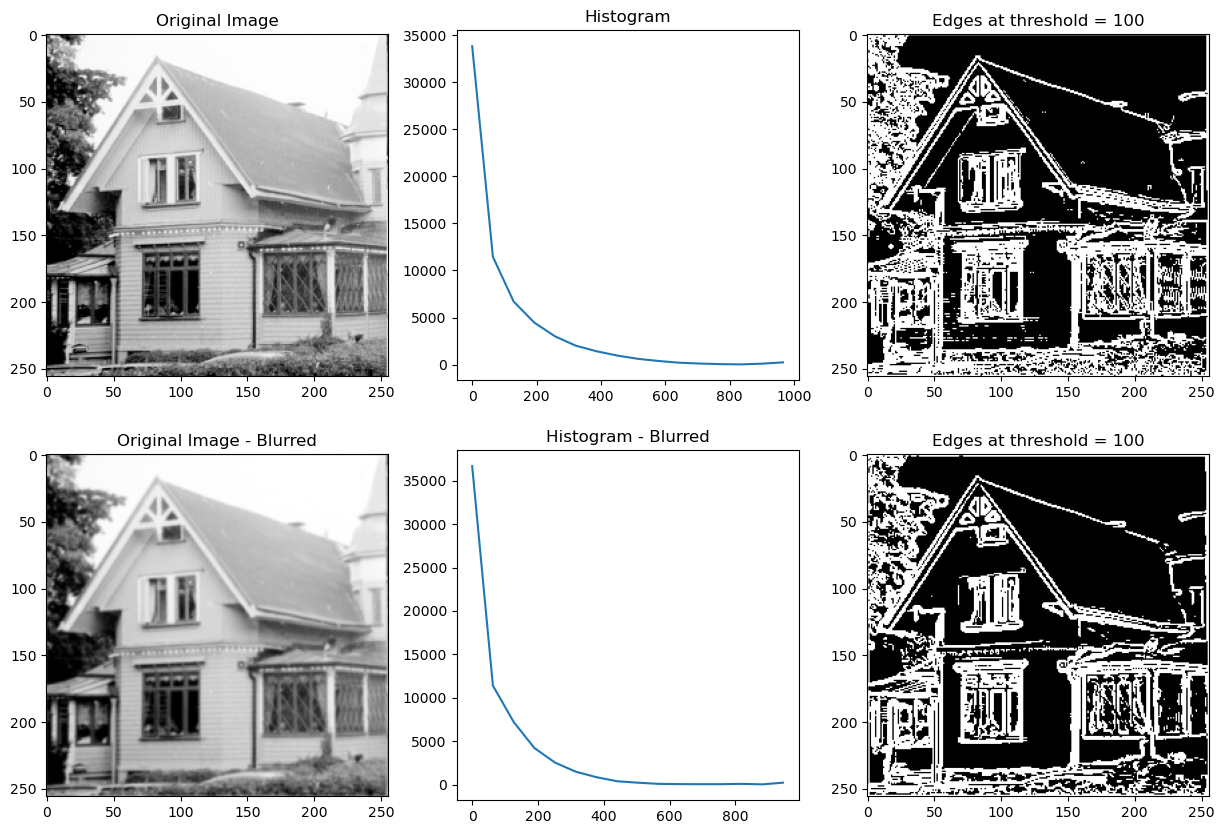

In [5]:
# @TODO fix this function
def q2():
    # Grabbing the image and computing the gradient
    tools = np.load("Images-npy/few256.npy")
    delta_x_img = delta_x(tools)
    delta_y_img = delta_y(tools)

    # Magnitude of the gradient
    magnitude = np.sqrt(delta_x_img**2 + delta_y_img**2)
    histogram = np.histogram(magnitude, bins=16)

    threshold = 16
    edges = magnitude > threshold
    # Plot the original, histogram and transformed image
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(tools, cmap="gray")
    ax[0].set_title("Original Image")
    ax[1].plot(histogram[1][:-1], histogram[0])
    ax[1].set_title("Histogram")
    ax[2].imshow(edges, cmap="gray")
    ax[2].set_title("Edges at threshold = {}".format(threshold))
    plt.show()

    # Now we gotta do the same for image godthem256
    godthem = np.load("Images-npy/godthem256.npy")
    godthem_blurred = np.real(gaussfft(godthem, 0.5))

    # Sobel filter to the blurred image and histogram
    magnitude_godthem = Lv(godthem)
    magnitude_godthem_blurred = Lv(godthem_blurred)

    # histogram of the images
    histogram_godthem = np.histogram(magnitude_godthem, bins=16)
    histogram_godthem_blurred = np.histogram(magnitude_godthem_blurred, bins=16)

    # threshold and edges
    threshold = 100

    edges_godthem = magnitude_godthem > threshold
    edges_godthem_blurred = magnitude_godthem_blurred > threshold

    # Create 2x3 subplots
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the original image
    ax[0, 0].imshow(godthem, cmap="gray")
    ax[0, 0].set_title("Original Image")

    # Plot the histogram
    ax[0, 1].plot(histogram_godthem[1][:-1], histogram_godthem[0])
    ax[0, 1].set_title("Histogram")

    # Plot the edges
    ax[0, 2].imshow(edges_godthem, cmap="gray")
    ax[0, 2].set_title("Edges at threshold = {}".format(threshold))

    # Plot the original image
    ax[1, 0].imshow(godthem_blurred, cmap="gray")
    ax[1, 0].set_title("Original Image - Blurred")

    # Plot the histogram
    ax[1, 1].plot(histogram_godthem_blurred[1][:-1], histogram_godthem_blurred[0])
    ax[1, 1].set_title("Histogram - Blurred")

    # Plot the edges
    ax[1, 2].imshow(edges_godthem_blurred, cmap="gray")
    ax[1, 2].set_title("Edges at threshold = {}".format(threshold))
    plt.show()


q2()

## Question 3:
Does smoothing the image help to find edges?

**Answer** <br>
Smoothing the image does help to find the edges. Smoothing reduces the noise which makes the edges more distinguishable. The blurring helps to merge pixel values in a region which makes them less sharp but more uniform. When edge detection algorithms are then used it becomes easier to identify the transitions in pixel values that denote edges.  <br>

Important to note that there are different types of blurring filters. You need to find the right balance of it. 

## Question 4 
What can you observe? Provide explaination based on the generated images. 

**Answer** <br>
The edges that become detected depends on the scale of the gaussian blur applied. Less blur means higher frequency edges are detected. More blur means less edges remain and thereby less stuff detected <br>

**From theory**: As there are many zero crossings in the image the second derivatives are shifting between negative and positives values. Smoothing the images causes less of the zero crossings. Smoothing too much however causes the edges to disappear and the image becomes too blurry. 

Below is the code:

The derivs are correct, start the next part


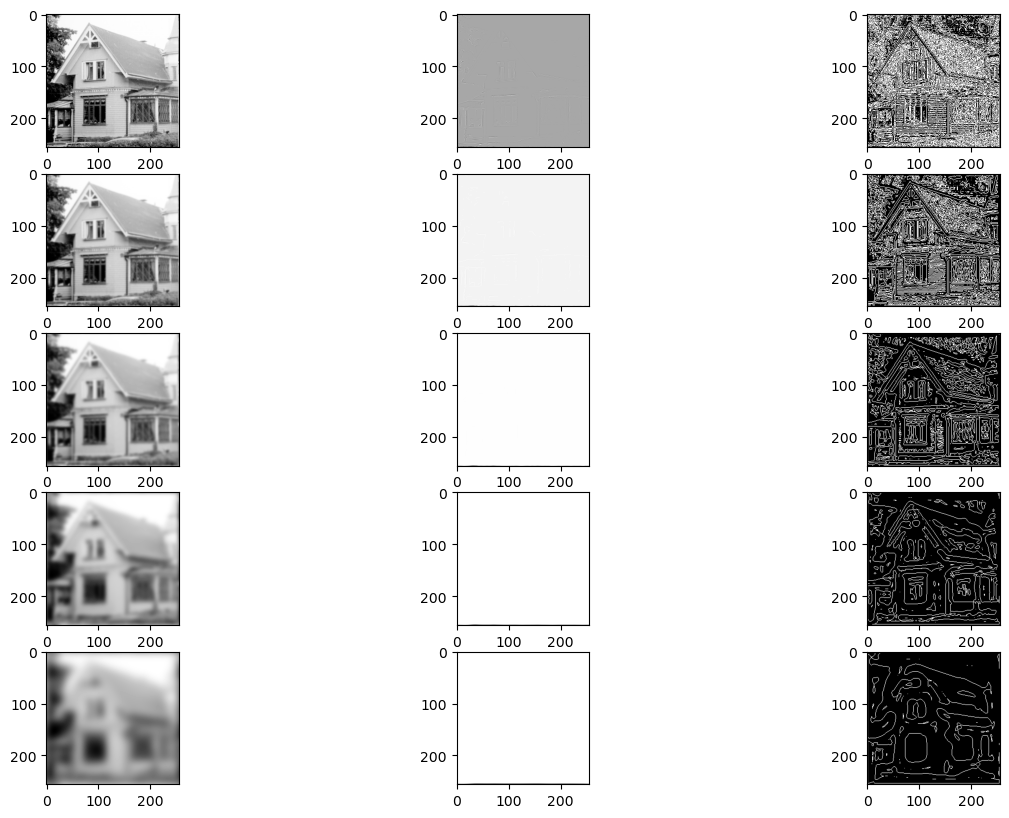

In [6]:
# First order derivative

dx_filter = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0.5, 0, -0.5, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
)
dy_filter = dx_filter.T

# Second order derivative
dxx_filter = np.array(
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 1, -2, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
    ]
)
dxy_filter = convolve2d(dx_filter, dy_filter, mode="same")
dyy_filter = dxx_filter.T

# Third order derivative --> We want the same size thereby same
dxxx_filter = convolve2d(dxx_filter, dx_filter, mode="same")
dxxy_filter = convolve2d(dxx_filter, dy_filter, mode="same")
dxyy_filter = convolve2d(dxy_filter, dy_filter, mode="same")
dyyy_filter = convolve2d(dyy_filter, dy_filter, mode="same")


def q4_gradient_checker():
    [x, y] = np.meshgrid(range(-5, 6), range(-5, 6))
    deriv_xxx = convolve2d(x**3, dxxx_filter, mode="valid")
    deriv_xx = convolve2d(x**2, dxx_filter, mode="valid")
    deriv_xxy = convolve2d(x**2 * y, dxxy_filter, mode="valid")
    deriv_higher = convolve2d(x, dxxx_filter, mode="valid")
    deriv_y_with_x = convolve2d(y, dxx_filter, mode="valid")

    # Analytical derivatives
    analytical_xxx = np.full(deriv_xxx.shape, 6)
    analytical_xx = np.full(deriv_xx.shape, 2)
    analytical_xxy = np.full(deriv_xxy.shape, 2)
    analytical_x = np.full(deriv_xxx.shape, 0)
    analytical_y_with_x = np.full(deriv_y_with_x.shape, 0)

    # Check if it derivates correct
    check_1 = np.allclose(deriv_xxx, analytical_xxx)
    check_2 = np.allclose(deriv_xx, analytical_xx)
    check_3 = np.allclose(deriv_xxy, analytical_xxy)
    check_4 = np.allclose(deriv_higher, analytical_x)
    check_5 = np.allclose(deriv_y_with_x, analytical_y_with_x)

    if (check_1 | check_2 | check_3 | check_4 | check_5) == False:
        return False
    else:
        return True
    

def q4():
    check_derivs = q4_gradient_checker()
    if not check_derivs:
        print("The derivatives are not correct")
    print("The derivs are correct, start the next part")

    # Load the image
    house_image = np.load("Images-npy/godthem256.npy")
    scale_values = [0.0001, 1.0, 4.0, 16.0, 64.0]
    
    # Create 5 x 3 subplots
    fig, ax = plt.subplots(5, 3, figsize=(15, 10))

    for scale in scale_values:
        house_image_blurr = discgaussfft(house_image, scale)
        lv_tilde = Lvvtilde(house_image_blurr, "same")
        contours = contour(lv_tilde)

        # Plot the blurred image
        ax[scale_values.index(scale), 0].imshow(house_image_blurr, cmap="gray")

        # Second column - LVV_tilde
        ax[scale_values.index(scale), 1].imshow(lv_tilde, cmap="gray")

        # Third column - Contours
        ax[scale_values.index(scale), 2].imshow(contours, cmap="gray")
 
q4()

## Question 5
Assemble the results of the experiments above into an illustrative collage with the subplot command. Which are your observations and conclusions?

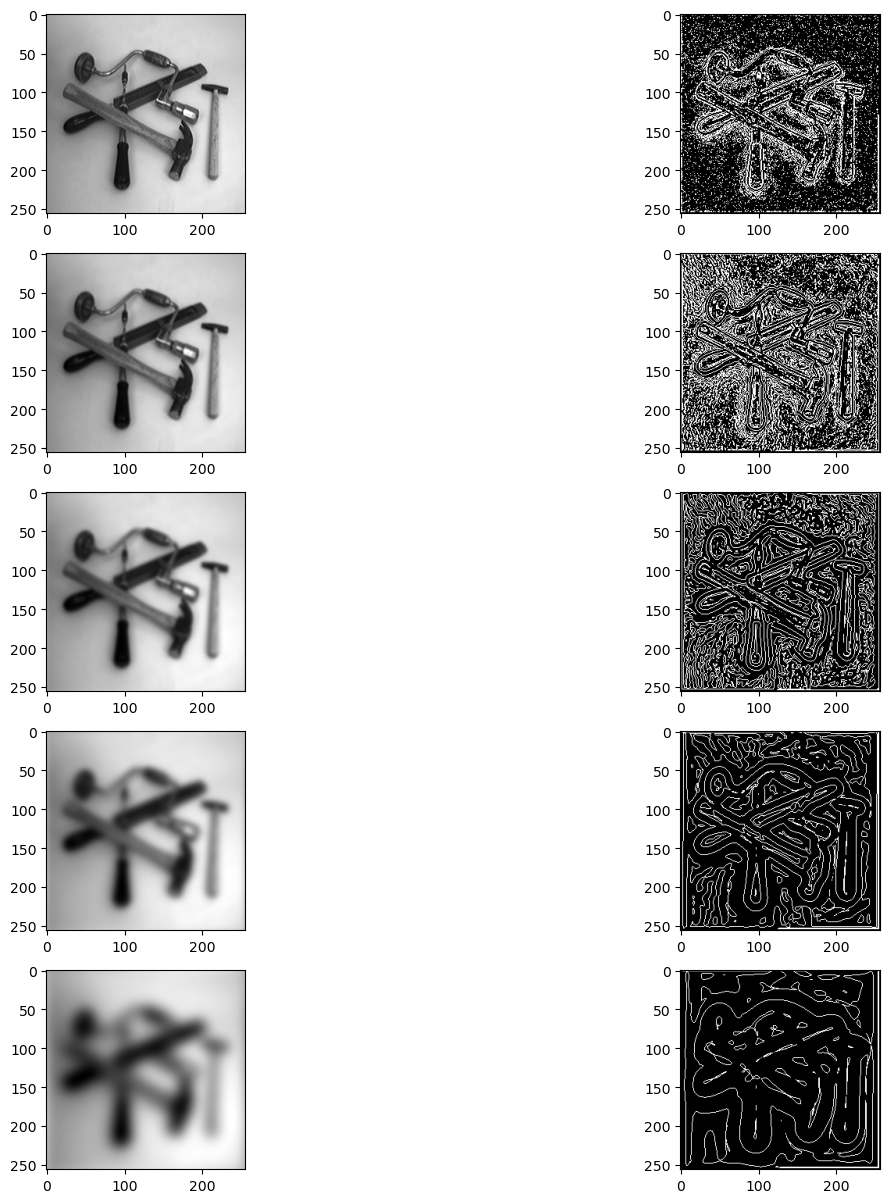

In [11]:
def q5():
    # Load the image
    house_image = np.load("Images-npy/few256.npy")
    scale_values = [0.0001, 1.0, 4.0, 16.0, 64.0]

    # Create 5 x 3 subplots
    fig, ax = plt.subplots(5, 2, figsize=(15, 15))

    for scale in scale_values:
        house_image_blurr = discgaussfft(house_image, scale)
        lvvv_tilde = (Lvvvtilde(house_image_blurr, "same"))
        contours = contour(lvvv_tilde)

        # Plot the blurred image
        ax[scale_values.index(scale), 0].imshow(house_image_blurr, cmap="gray")

        # second column - Contours
        ax[scale_values.index(scale), 1].imshow(contours, cmap="gray")

    plt.show()


q5()

## Question 6:
How can you use the reponse from $ \hat{L}_{vv} $ to detect edges and how can you improve the result by using $\hat{L}_{vvv}$?

## Question 7
Present your best results obtained with extractedge() for house and tools 

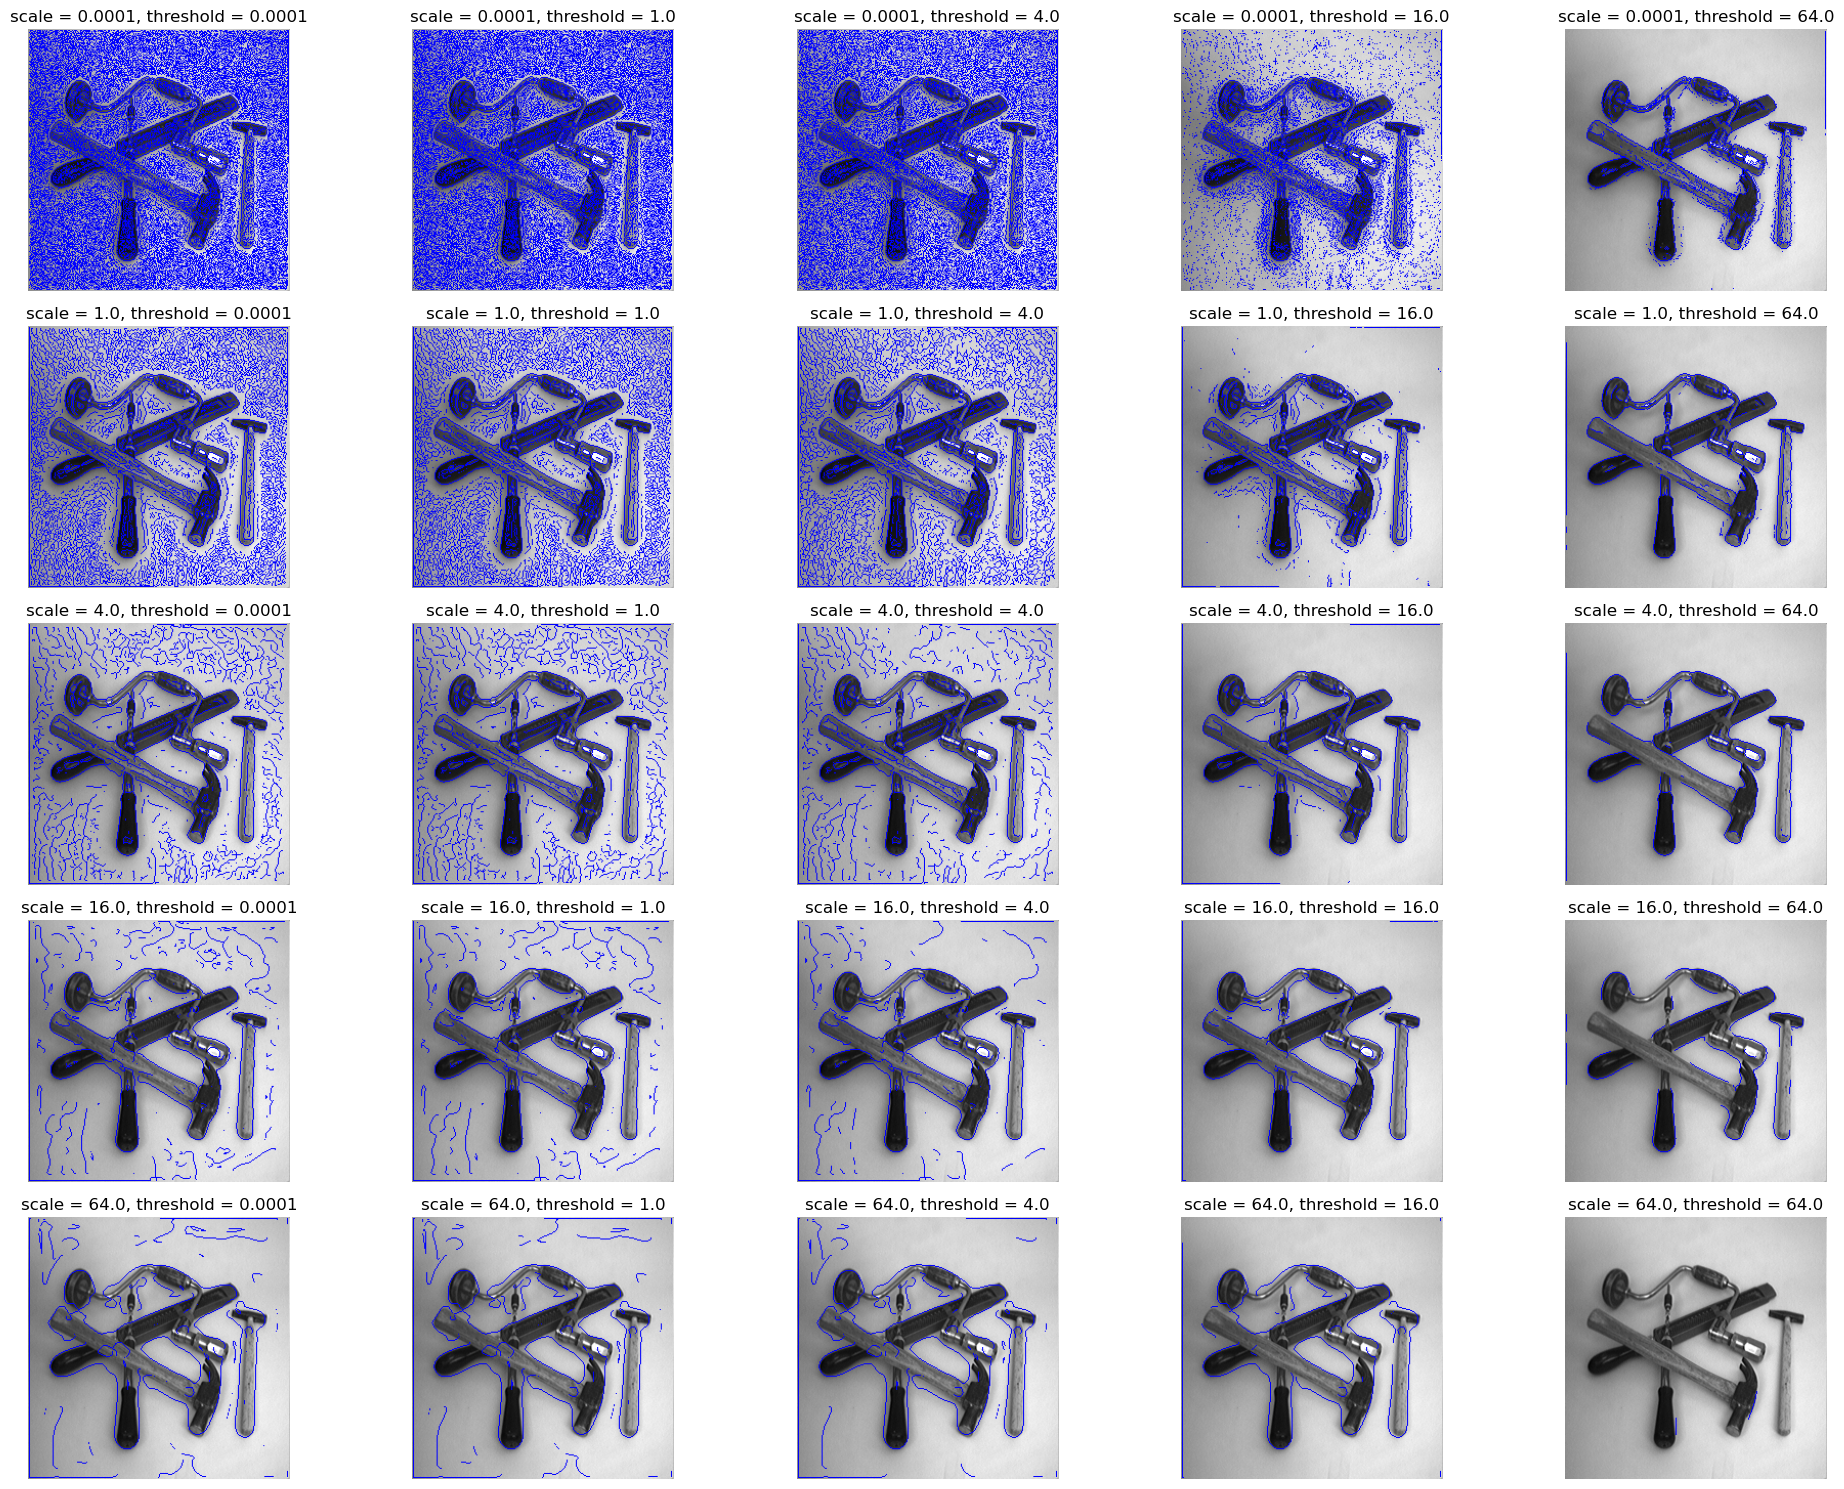

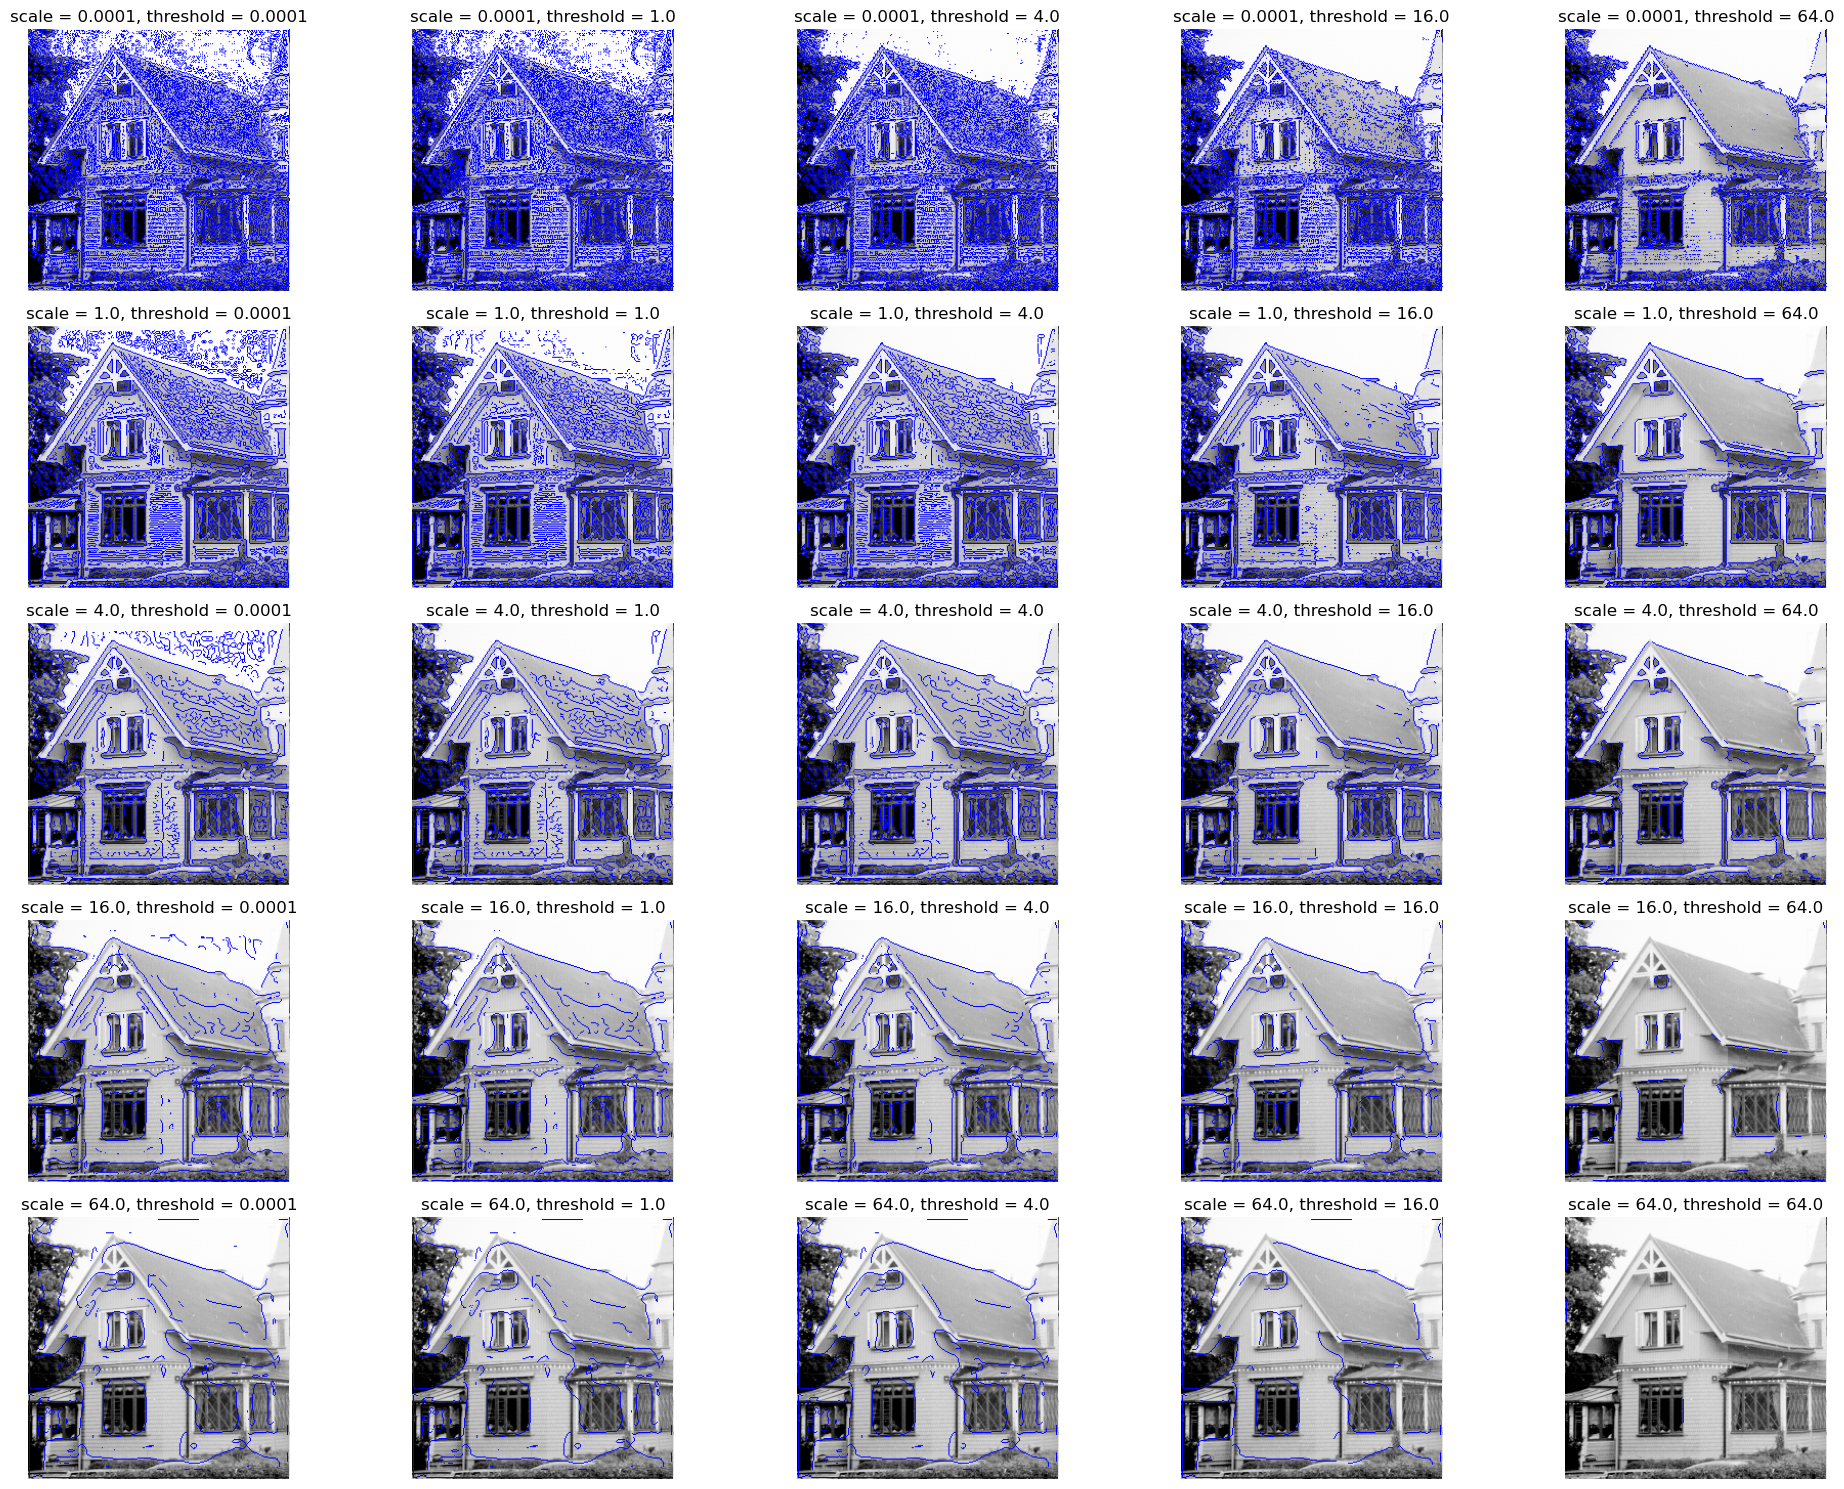

In [8]:
def q7():
    house = np.load("Images-npy/godthem256.npy")
    tools = np.load("Images-npy/few256.npy")

    scales = [0.0001, 1.0, 4.0, 16.0, 64.0]
    threshold_values = [0.0001, 1.0, 4.0, 16.0, 64.0]

    # Create 5 x 5 subplots with increased figure size
    fig, ax = plt.subplots(5, 5, figsize=(20, 15))

    for scale in scales:
        for threshold in threshold_values:
            contours = extractedge(tools, scale, threshold)
            rgb_values = overlaycurves_EDITED(tools, contours, False)
            ax_idx = (scales.index(scale), threshold_values.index(threshold))
            ax[ax_idx].imshow(rgb_values)
            ax[ax_idx].title.set_text(f"scale = {scale}, threshold = {threshold}")
            ax[ax_idx].axis("off")  # Turn off axis ticks

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots
    plt.tight_layout()  # Adjust layout
    plt.show()

    # Do the same for house
    # Create 5 x 5 subplots with increased figure size
    fig, ax = plt.subplots(5, 5, figsize=(20, 15))

    for scale in scales:
        for threshold in threshold_values:
            contours = extractedge(house, scale, threshold)
            rgb_values = overlaycurves_EDITED(house, contours, False)
            ax_idx = (scales.index(scale), threshold_values.index(threshold))
            ax[ax_idx].imshow(rgb_values)
            ax[ax_idx].title.set_text(f"scale = {scale}, threshold = {threshold}")
            ax[ax_idx].axis("off")

    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots
    plt.tight_layout()  # Adjust layout
    plt.show()



q7()

## Question 8
Identify the correspondences between the strongest peaks in the accumulator and line segments in the output image. Doing so convince yourself that the implementation is correct. Summarize the results in one or more figures.


In [9]:
def houghline(curves, magnitude, nrho, ntheta, threshold, nlines=20, verbose=False):
    # Building the accumulator array
    accumulator = np.zeros((nrho, ntheta))

    # Coodinate system of accumulator space
    radius = np.sqrt((magnitude.shape[0] ** 2) + (magnitude.shape[1] ** 2))
    rho = np.linspace(-radius, radius, nrho)
    theta = np.linspace(-np.pi / 2, np.pi / 2, ntheta)

    # Loop over all edges to find potential lines
    for edge in range(len(curves[0])):
        x = curves[0][edge]
        y = curves[1][edge]
        edge_magnitude = magnitude[x][y]
        if edge_magnitude > threshold:
            # Loop over all the theta (angle) values
            for angle in range(len(theta)):
                # Calculate the rho(starting point) for each theta
                rho_value = x * np.cos(theta[angle]) + y * np.sin(theta[angle])
                # Find the closest rho value in the rho array
                rho_index = np.argmin(np.abs(rho - rho_value))
                # Increment the accumulator array
                accumulator[rho_index][angle] += 1

    # Find the nlines most dominant lines
    all_lines = []
    # Grab the local maxima:
    pos, value, _ = locmax8(accumulator)
    index_vector = np.argsort(value)[-nlines:]
    position = pos[index_vector]

    for theta_index, rho_index in position[:nlines]:
        # Calculate the rho and theta value
        rho_final = rho[rho_index]
        theta_final = theta[theta_index]
        all_lines.append([rho_final, theta_final])

    if verbose:
        print("no sorry")

    return all_lines, accumulator




# @TODO: Implement this function
def houghedgelines(
    pic, scale, gradmagnthreshold, nrho, ntheta, nlines=20, verbose=False
):
    # Get the edges
    edges = extractedge(pic, scale, gradmagnthreshold)
    # Get the magnitude
    magnitude = Lv(pic)
    # Grab the lines
    lines, accumulator = houghline(
        edges, magnitude, nrho, ntheta, gradmagnthreshold, nlines, verbose
    )
    return lines, accumulator

def q8():
    # Load the image
    house = np.load("Images-npy/godthem256.npy")
    tools = np.load("Images-npy/few256.npy")

q8()